In [ ]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git
%cd uni2ts
!pip install -e .

In [54]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
from uni2ts.eval_util.data import get_custom_eval_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from utils import *
import pickle
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [69]:
# EVAL PARAMS
benchmark_folder = 'data/project1_data'
run_name = benchmark_folder.split('/')[-1]
results_folder = 'results'
eval_start = '2020-01-01'  # start eval period
eval_end = '2024-10-01'  # end eval period
device = 'cuda'  # choose from 'cuda' or 'cpu'

# MODEL PARAMS
size = "small"  # choose from "small", "base", "large". Moirai-MoE no "large".
use_x = True  # use X covariates or not
CTX = 300  # context length: how many past values to use to make predictions
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 1  # batch size
PDT = 1  # prediction length (how many months in the future to predict)
# MODEL PARAMS NOT TO CHANGE
offset = None  # point in the timeseries from where to start predictions
windows = None  # number of prediction window
dist = 1  # dist between each window

# MODEL SELECTION
# model_path = f'Salesforce/moirai-1.0-R-{size}'  # if using Moirai HF model
model_path = f'model_{size}'  # if using Moirai local model
# model_path = f'Salesforce/moirai-moe-1.0-R-{size}'  # if using Moirai-MoE HF model
# model_path = f'moirai_moe_{size}'  # if using Moirai-MoE local model
model_name = model_path.split('/')[-1]

In [56]:
datasets = {
    '20241031_汇率数据集': ['即期汇率(16:30):100日元兑人民币', '即期汇率(16:30):欧元兑人民币', '即期汇率(16:30):美元兑人民币'],
    '20241031_bond_interest_US_dataset': ['GOLD'],
    '20241031_利率数据集': ['中债国债10年全价', '中债国债5-7年全价', '中债国债1-3年全价'],
    '20241031_上证综指数据集': ['closeIndex'],
    '20241031_南华商品数据集': ['product_closeIndex'],
}
datasets_dict = load_datasets_from_folder(benchmark_folder)
print(f'Loaded {len(datasets_dict)} datasets: ', datasets_dict.keys())

In [59]:
for key, df in datasets_dict.items():
    for target_col in datasets[key]:
        print(f'{f"{key}_{target_col}"} inference started...')
        if use_x:
            covariates = [col for col in df.columns if col != target_col]
        else:
            covariates = []
        test_set_points = len(df[(df.index >= eval_start) & (df.index < eval_end)])
        df = df[df.index < eval_end]
        print(f'Test set len for {f"{key}_{target_col}"}: {test_set_points}')

        offset = -test_set_points
        windows = test_set_points
        train_data, test_data, ds = prepare_ds_dataset(df, covariates, target_col, offset, PDT, windows, dist)

        model = generate_model(model_path, size, pdt=PDT, ctx=CTX, psz=PSZ, fdrm=ds.num_feat_dynamic_real, device=device, num_samples=100)
        predictor = model.create_predictor(batch_size=BSZ)
        forecasts = list(predictor.predict(test_data.input))

        preds = np.array([f.mean[PDT-1] for f in forecasts])
        pred_series = pd.Series(data=[pred.item() for pred in preds], index=df.index[-windows:])
        real_value_series = pd.Series(data=df[target_col][-windows:], index=df.index[-windows:])

        results_dict[key + '_' + target_col] = (pred_series, real_value_series)
        print(f'{f"{key}_{target_col}"} inference completed')

Test set len for 20241031_上证综指数据集: 57
Loading weights from local directory
Test set len for 20241031_利率数据集: 57
Loading weights from local directory


/home/liudawei/anaconda3/envs/timeseries/lib/python3.11/site-packages/gluonts/transform/feature.py:161: RuntimeWarning: invalid value encountered in divide
  ar_res = cumsum / indices.astype(float)


Test set len for 20241031_利率数据集: 57
Loading weights from local directory


/home/liudawei/anaconda3/envs/timeseries/lib/python3.11/site-packages/gluonts/transform/feature.py:161: RuntimeWarning: invalid value encountered in divide
  ar_res = cumsum / indices.astype(float)


Test set len for 20241031_利率数据集: 57
Loading weights from local directory


/home/liudawei/anaconda3/envs/timeseries/lib/python3.11/site-packages/gluonts/transform/feature.py:161: RuntimeWarning: invalid value encountered in divide
  ar_res = cumsum / indices.astype(float)


Test set len for 20241031_南华商品数据集: 57
Loading weights from local directory
Test set len for 20241031_汇率数据集: 57
Loading weights from local directory


/home/liudawei/anaconda3/envs/timeseries/lib/python3.11/site-packages/gluonts/transform/feature.py:161: RuntimeWarning: invalid value encountered in divide
  ar_res = cumsum / indices.astype(float)


Test set len for 20241031_汇率数据集: 57
Loading weights from local directory
Test set len for 20241031_汇率数据集: 57
Loading weights from local directory
Test set len for 20241031_bond_interest_US_dataset: 57
Loading weights from local directory


In [86]:
def compute_directional_accuracy(pred, actual, only_sign=False):
    """
    Computes the directional accuracy between predicted and actual values.

    Args:
        pred (numpy.ndarray): The predicted values.
        actual (numpy.ndarray): The actual values.
        only_sign (bool, optional): If True, compares only the signs of the values. Defaults to False.

    Returns:
        float: The directional accuracy.
    """
    actual = actual.values if not isinstance(actual, np.ndarray) else actual
    pred = pred.values if not isinstance(pred, np.ndarray) else pred
    last_actual = actual[:-1]
    diff_pred = pred[1:] - last_actual
    diff_actual = actual[1:] - last_actual
    if only_sign:
        return np.mean(np.sign(pred) == np.sign(actual))
    else:
        return np.mean(np.sign(diff_pred) == np.sign(diff_actual))


def compute_metrics(results, buffer1=None, buffer2=None):
    """
    Computes and prints various metrics for the given results.

    Args:
        results (dict): A dictionary where keys are feature names and values are tuples of (predictions, actual values).
        buffer1 (float, optional): Buffer value for adjusting predictions close to actual values. Defaults to None.
        buffer2 (float, optional): Buffer value for adjusting predictions far from actual values. Defaults to None.

    Returns:
        None
    """
    table_data = []
    headers = ["Feature", "MSE", "MAE", "DA", "MAPE", "R2"]

    for key in results.keys():
        actual = results[key][1]
        preds = results[key][0]
        if buffer1 is not None:
            buffer = buffer1 * np.std(actual)
            close_values = np.abs(preds - actual) < buffer
            preds = np.where(close_values, actual, preds)
        if buffer2 is not None:
            buffer = buffer2 * np.std(actual)
            far_values = np.abs(preds - actual) > buffer
            preds = np.where(close_values, actual, actual + buffer)

        mse_test = mean_squared_error(np.array(preds), np.array(actual))
        mae_test = mean_absolute_error(np.array(preds), np.array(actual))

        directional_accuracy_test = compute_directional_accuracy(np.array(preds), np.array(actual), only_sign=False)

        # Compute MAPE (avoiding division by zero)
        mape_test = np.mean(np.abs((actual - preds) / actual)) if np.any(actual != 0) else float('inf')

        # Compute Pearson correlation coefficient (R)
        r_test = np.corrcoef(preds, actual)[0, 1] if preds.size > 1 else float('nan')

        # Append the results to the table
        table_data.append([
            key,
            mse_test,
            mae_test,
            directional_accuracy_test,
            mape_test,
            r_test
        ])

    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-----------------------------------------------------+---------------+------------+----------+------------+----------+
| Feature                                             |           MSE |        MAE |       DA |       MAPE |       R2 |
+=====================================================+===============+============+==========+============+==========+
| 20241031_上证综指数据集_closeIndex                  | 19394.1       | 118.111    | 0.785714 | 0.037152   | 0.95115  |
+-----------------------------------------------------+---------------+------------+----------+------------+----------+
| 20241031_利率数据集_中债国债10年全价                |    15.342     |   2.4881   | 0.946429 | 0.0196732  | 0.950421 |
+-----------------------------------------------------+---------------+------------+----------+------------+----------+
| 20241031_利率数据集_中债国债5-7年全价               |     2.72476   |   1.11484  | 0.946429 | 0.008112   | 0.946998 |
+-----------------------------------------------------+---------------+

In [ ]:
print('Metrics result')
compute_metrics(results_dict, buffer1=0.2, buffer2=0.7)

In [70]:
os.makedirs(results_folder, exist_ok=True)
output_file = os.path.join(results_folder, f'{model_name}_{run_name}_metrics.pkl')
with open(output_file, 'wb') as file:
    pickle.dump(results_dict, file)
print(f"Results dictionary saved to '{output_file}'")

Results dictionary saved to 'results/moirai_moe_base_project1_data_metrics.pkl'


Plot predictions for: 20241031_上证综指数据集_closeIndex


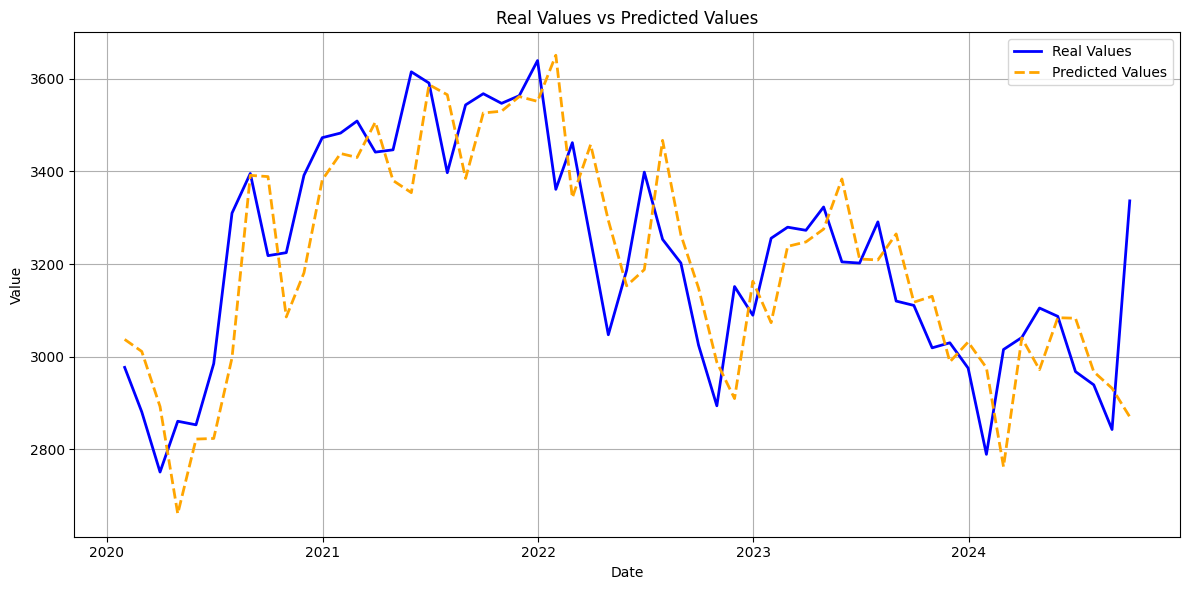

Plot predictions for: 20241031_利率数据集_中债国债10年全价


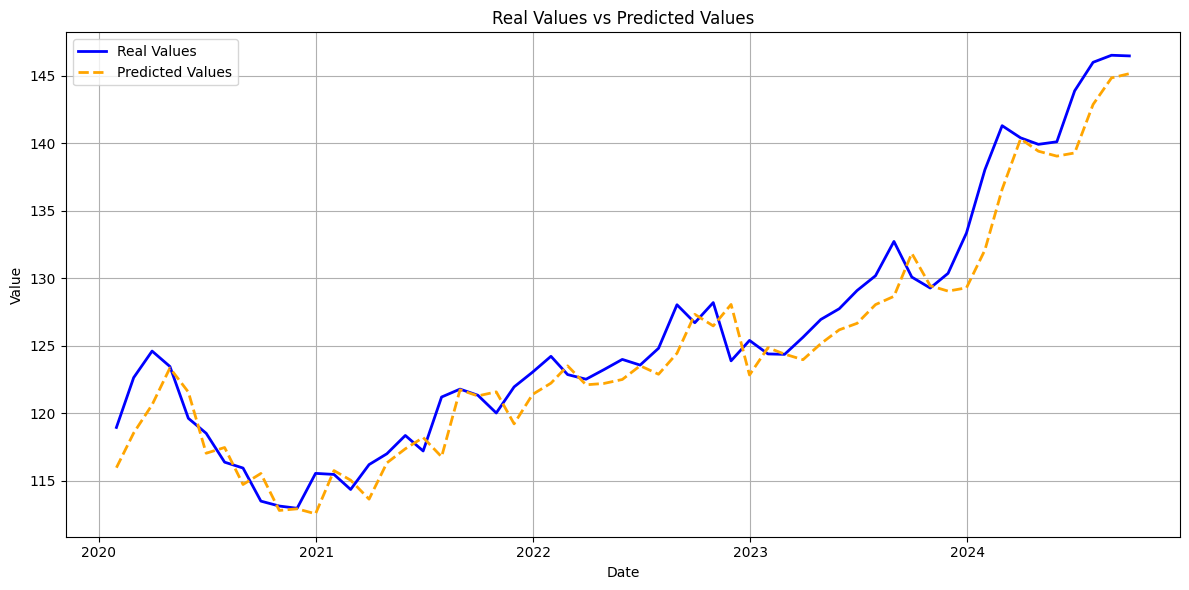

Plot predictions for: 20241031_利率数据集_中债国债5-7年全价


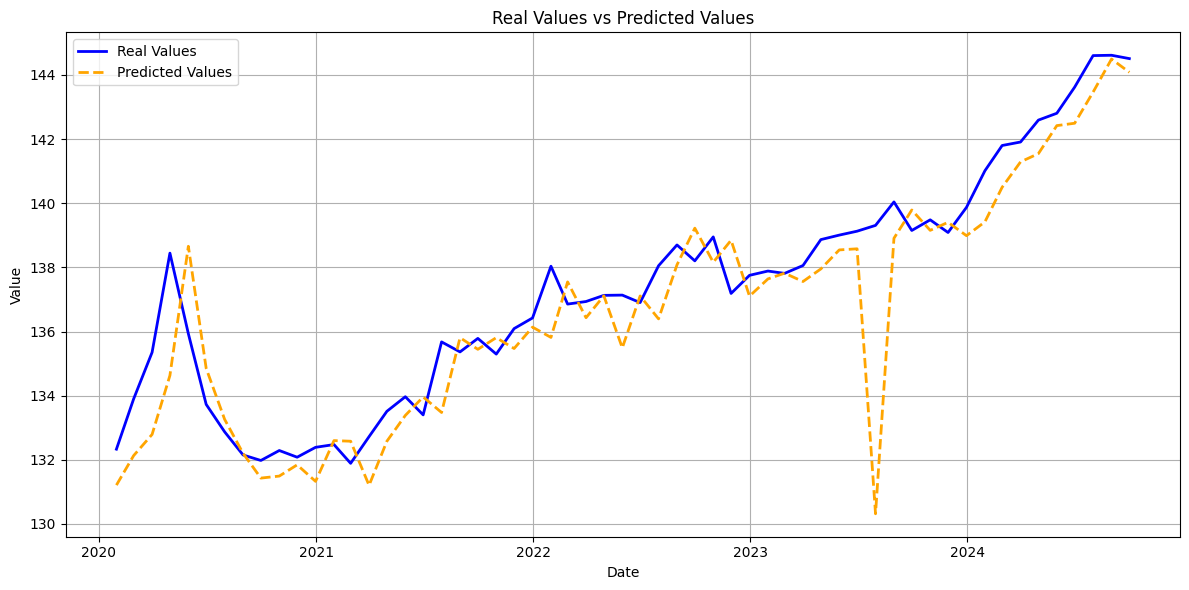

Plot predictions for: 20241031_利率数据集_中债国债1-3年全价


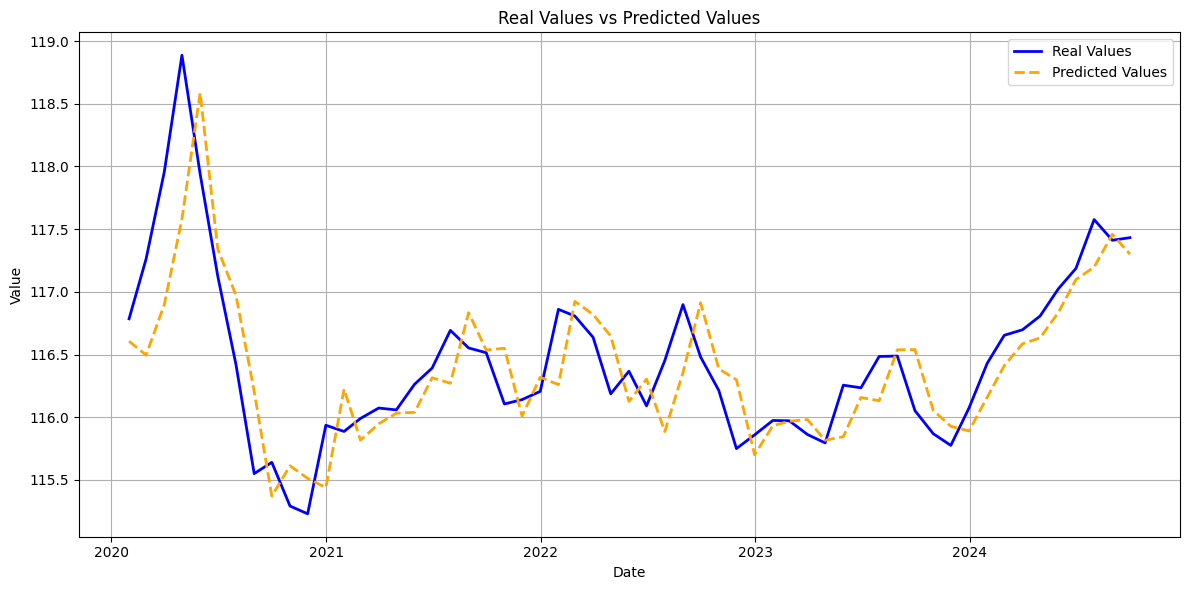

Plot predictions for: 20241031_南华商品数据集_product_closeIndex


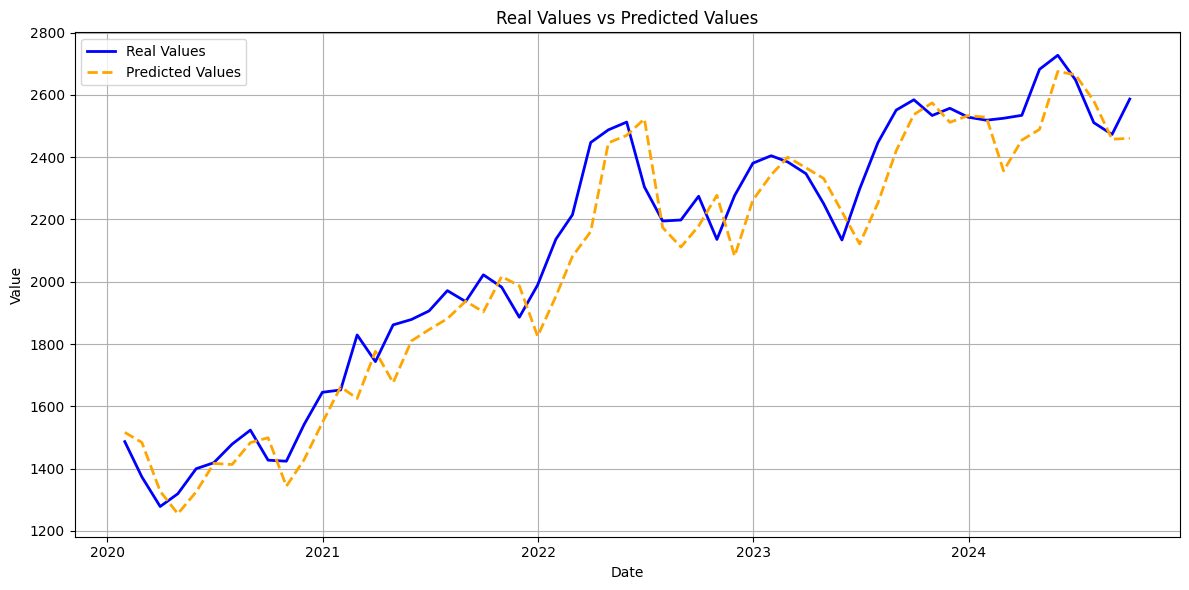

Plot predictions for: 20241031_汇率数据集_即期汇率(16:30):100日元兑人民币


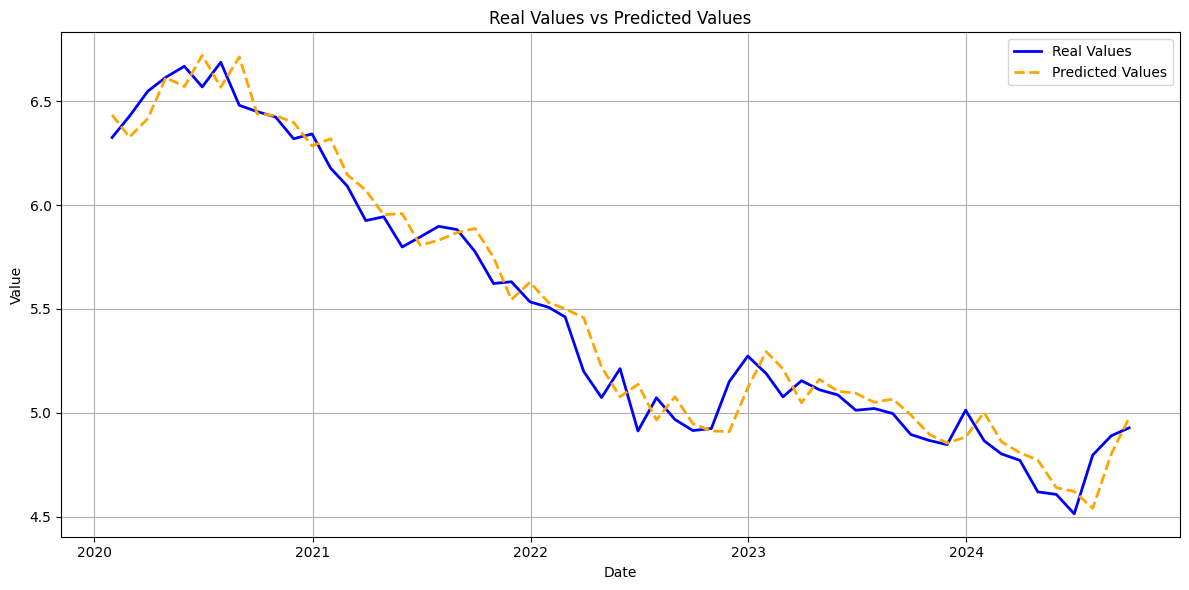

Plot predictions for: 20241031_汇率数据集_即期汇率(16:30):欧元兑人民币


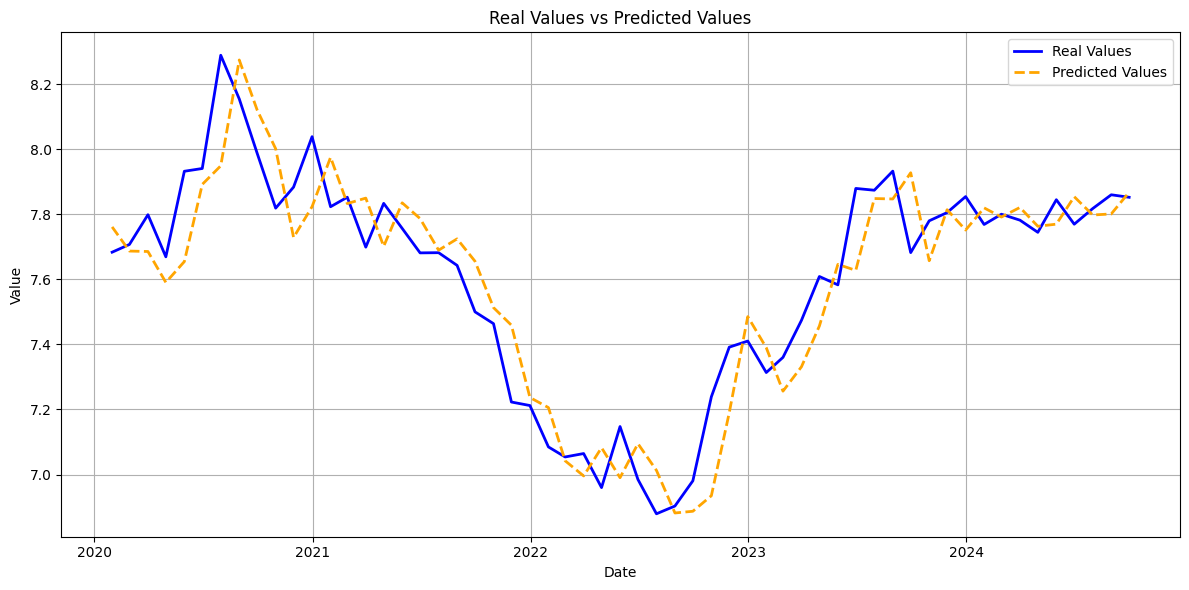

Plot predictions for: 20241031_汇率数据集_即期汇率(16:30):美元兑人民币


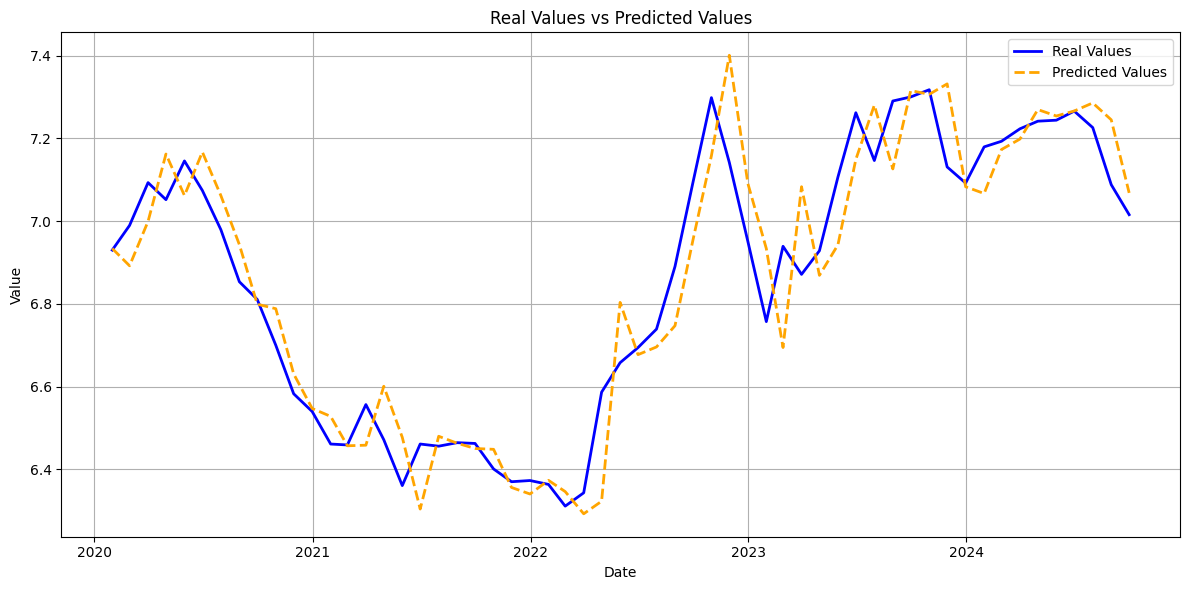

Plot predictions for: 20241031_bond_interest_US_dataset_GOLD


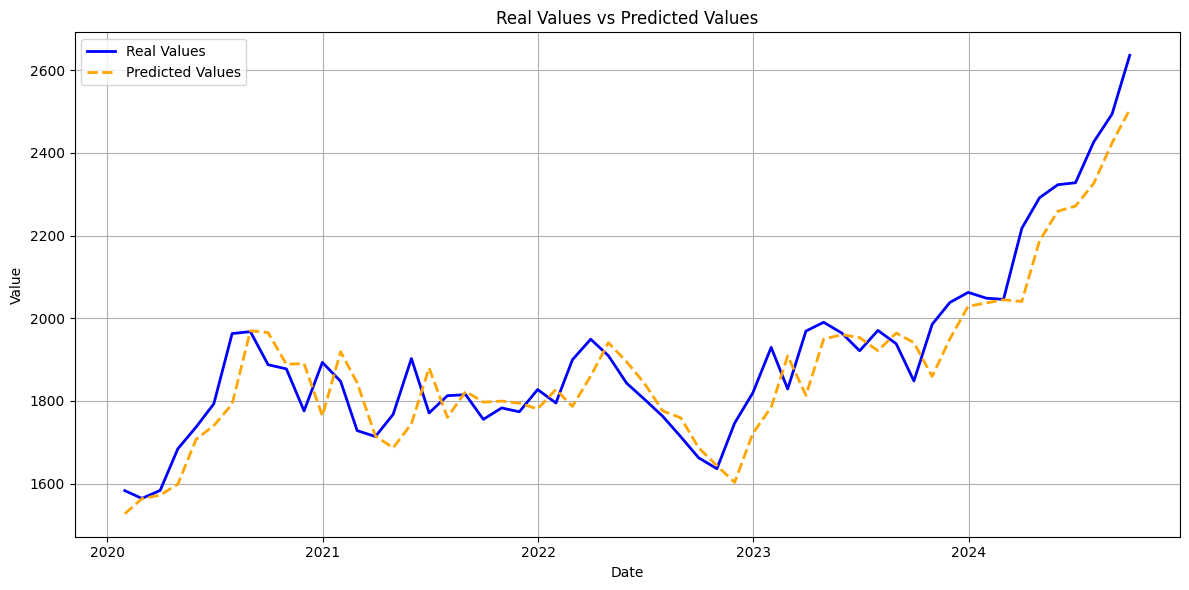

In [71]:
for key in results_dict.keys():
    print(f'Plot predictions for: {key}')
    plot_real_vs_predicted(results_dict[key][1], results_dict[key][0])